In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata

In [3]:
sys.path.append("/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/")

In [684]:
import RNAseq
importlib.reload(RNAseq)

<module 'RNAseq' from '/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/RNAseq.py'>

In [5]:
cell_line = "HCC70"
project = "DSP992"

### Plotting parameters

In [348]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [7]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-BC-cell-lines_{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/raw_cb_frequency.txt", header=None)[1]

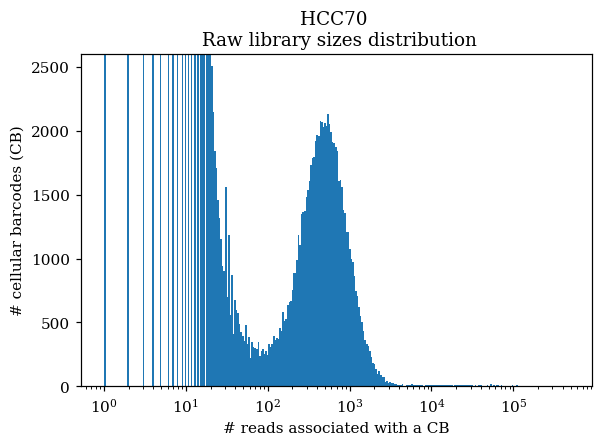

In [8]:
plt.title(f"{cell_line} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
RNAseq.plot_loghist(y, bins=300)

In [9]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-BC-cell-lines_{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/featureDump.txt")

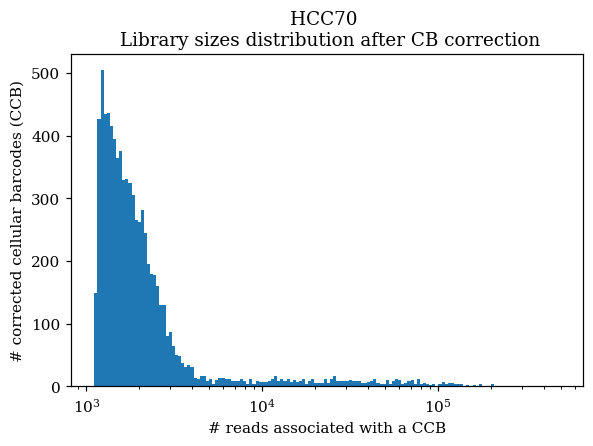

In [10]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["CorrectedReads"], bins=150)

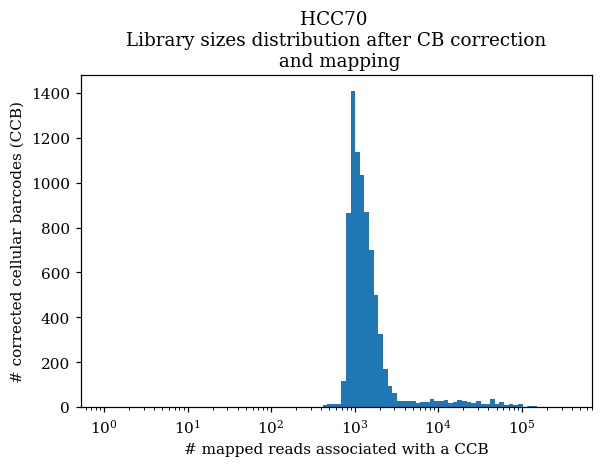

In [11]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["MappedReads"], bins=100)

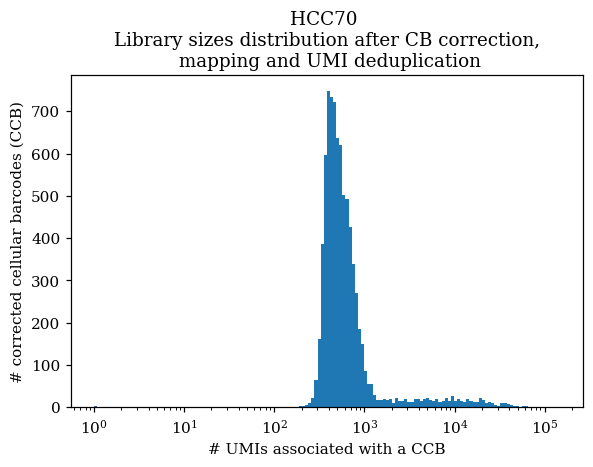

In [12]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["DeduplicatedReads"], bins=150)

### Loading raw count matrix

In [685]:
sc = RNAseq.sc_Dataset(project_path = f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-BC-cell-lines_{project}", samples_id = "cell_lines", samples= [cell_line], quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "raw", cdna = "3' tag")
# sc.annotate_genes(annot_name = "external_gene_name")
# sc.annotate_genes(annot_name = "chromosome_name")
# sc.annotate_samples(annot_name= "mt_frac")
# sc.annotate_samples(annot_name= "rp_frac")
sc.save()

Annotating cell_lines...
Annotating barcodes...


In [45]:
sc.mtx.shape

(7999, 20305)

### Non stringent filtering

In [705]:
sc.reload()

In [664]:
sc.mtx.shape

(7999, 20305)

__QC before filtering__

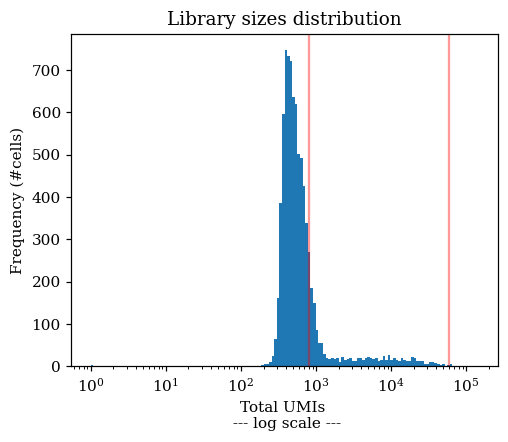

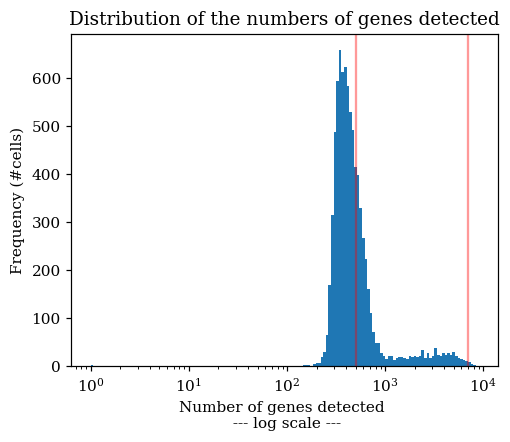

Annotating max_corr...


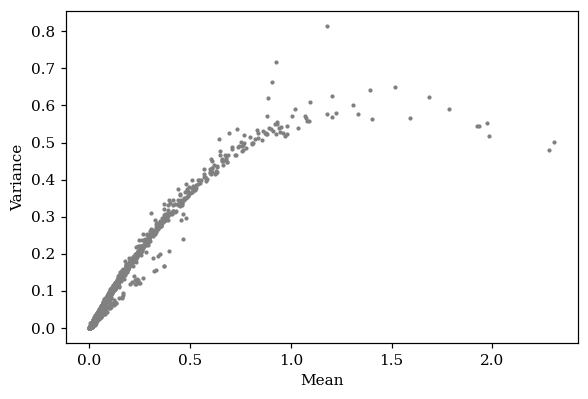

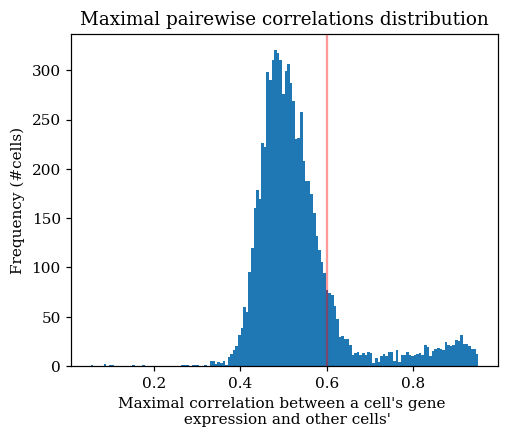

Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


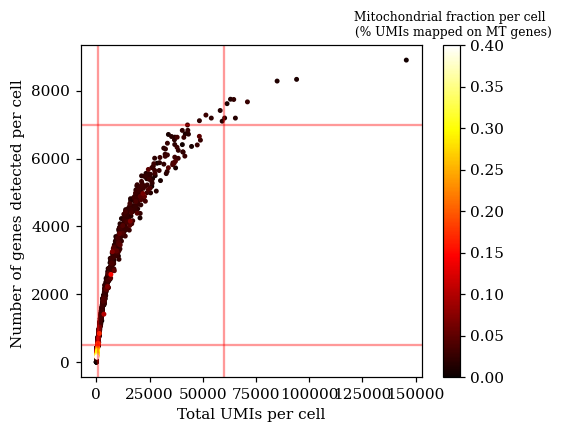

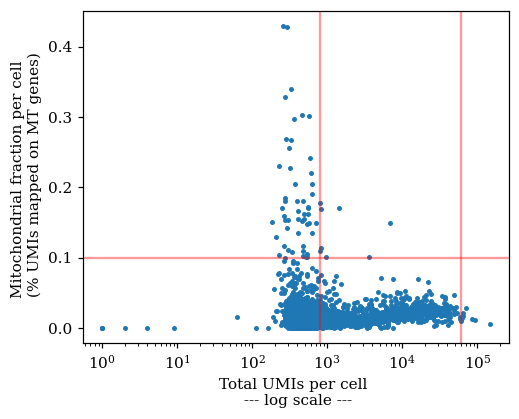

In [686]:
sc.plot_qc(n_counts_max=60000, n_counts_min = 800, n_genes_max=7000, n_genes_min = 500, mt_max = 0.1, max_corr_thr = 0.6, n_bins = 150)
sc.save()

__Filtering cells__

In [706]:
sc.filter_cells(n_counts_max=60000, n_counts_min = 800, n_genes_max=7000, n_genes_min = 500, mt_max = 0.1, max_corr_thr=0.6);
sc_ns = sc.copy()
sc_ns.save()

In [697]:
sc.mtx.shape

(1080, 20305)

In [698]:
sc_ns.mtx.shape

(1080, 20305)

__QC after filtering__

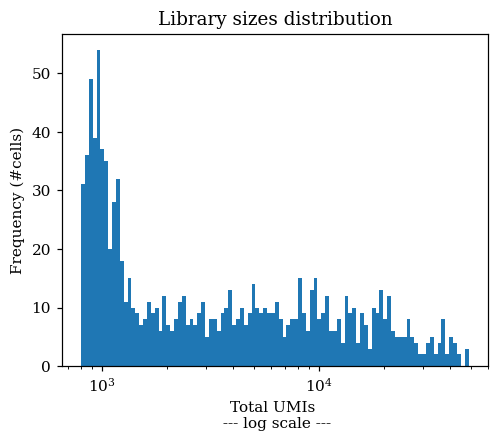

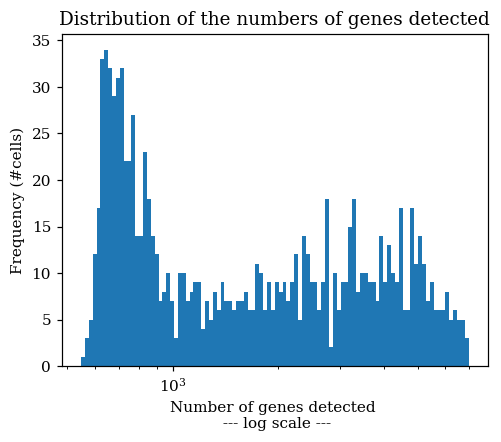

max_corr already annotated. Set ow = True if you want to overwrite.


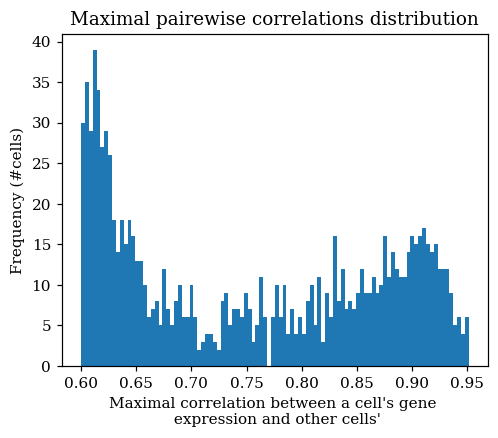

mt_frac already annotated. Set ow = True if you want to overwrite.


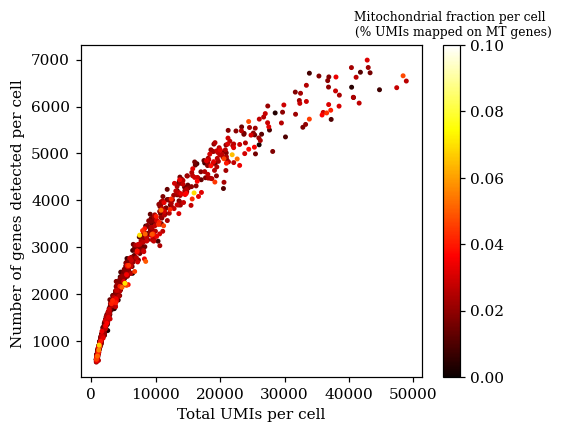

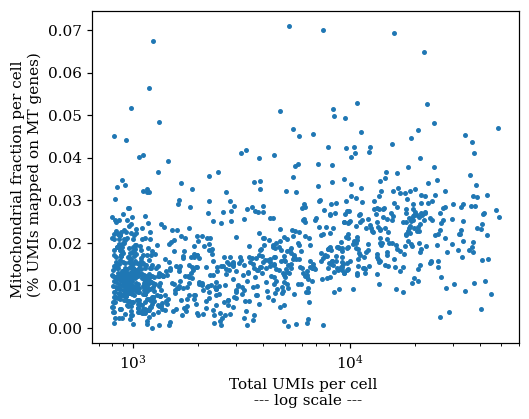

In [107]:
sc_ns.plot_qc(show_cutoffs=False)

__Saving filtered count matrix__

In [19]:
# sc.save_files(pp="filtered/non-stringent")

### Stringent filtering

In [707]:
sc.reload()

__QC__

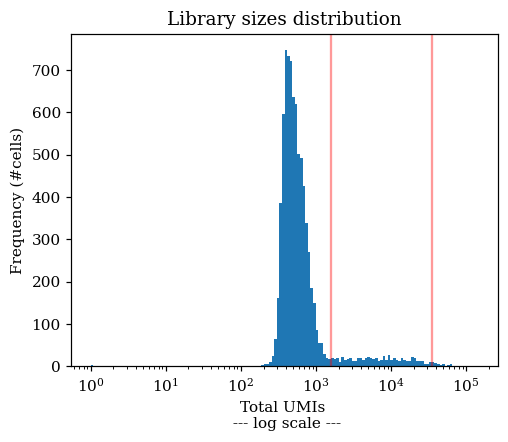

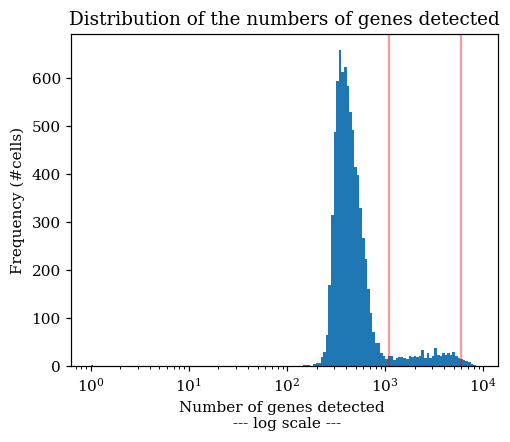

max_corr already annotated. Set ow = True if you want to overwrite.


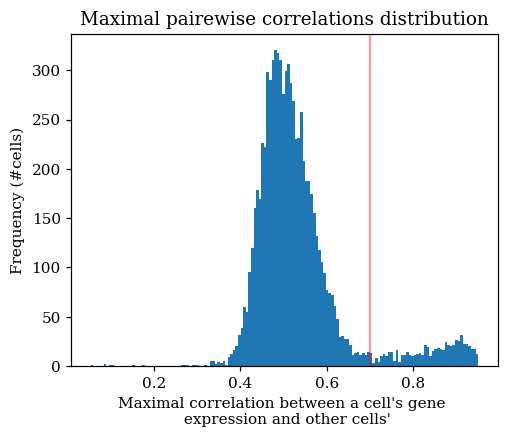

mt_frac already annotated. Set ow = True if you want to overwrite.


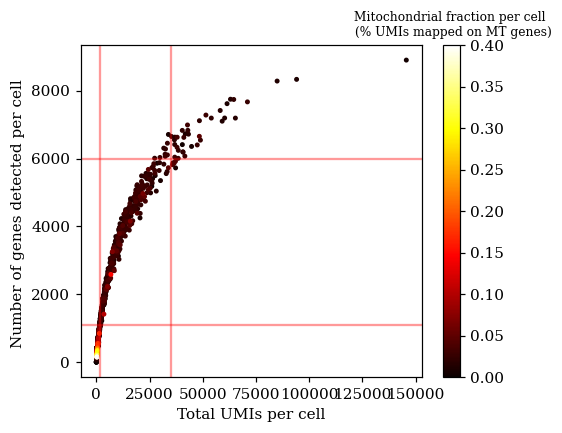

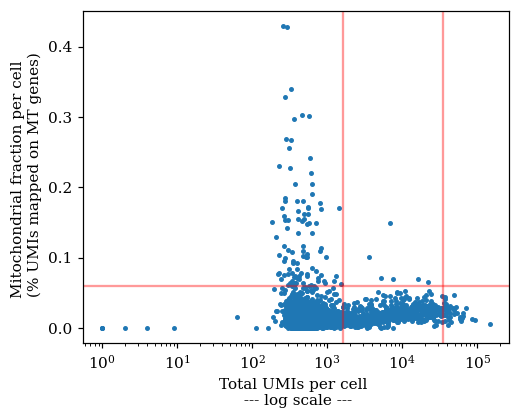

In [689]:
sc.plot_qc(n_counts_max=35000, n_counts_min = 1600, n_genes_max=6000, n_genes_min = 1100, mt_max = 0.06, max_corr_thr = 0.7, n_bins=150)

__Filtering cells__

In [708]:
sc.filter_cells(n_counts_max=35000, n_counts_min = 1600, n_genes_max=6000, n_genes_min = 1100, mt_max = 0.06, max_corr_thr = 0.7);
sc_s = sc.copy()
sc_s.save()

In [701]:
sc.mtx.shape

(552, 20305)

In [702]:
sc_s.mtx.shape

(552, 20305)

__QC after filtering__

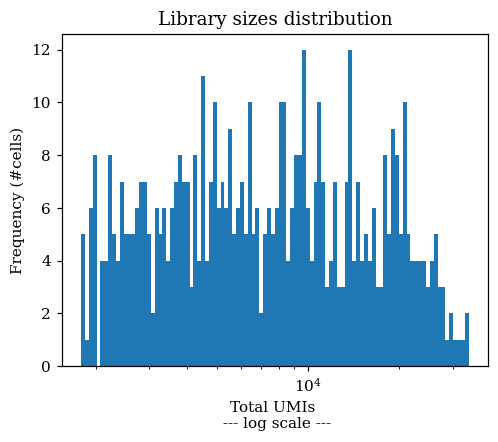

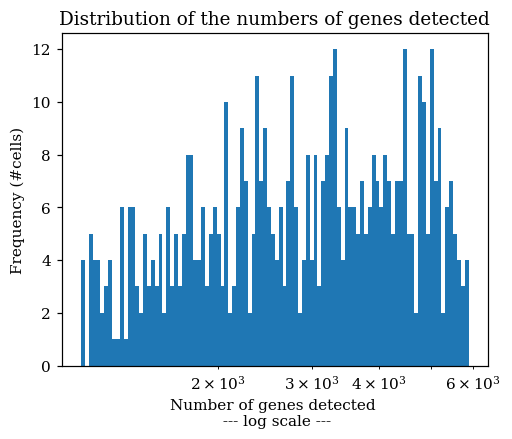

max_corr already annotated. Set ow = True if you want to overwrite.


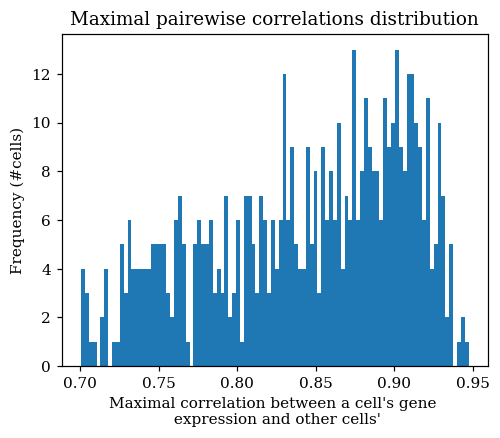

mt_frac already annotated. Set ow = True if you want to overwrite.


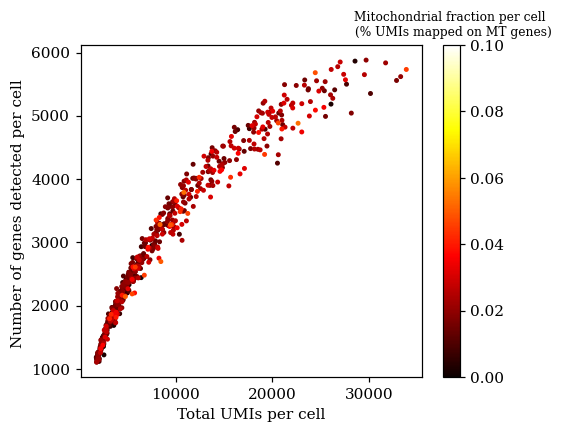

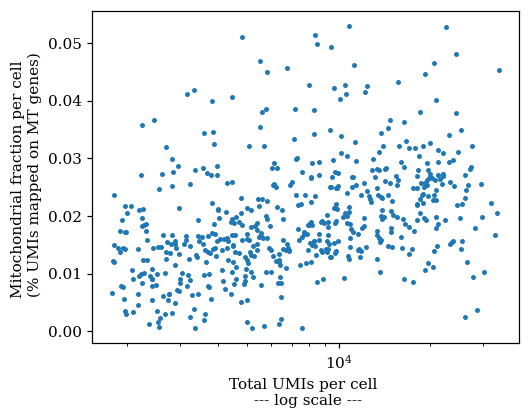

In [121]:
sc_s.plot_qc(show_cutoffs=False)

__Saving filtered count matrix__

In [25]:
# sc.save_files(pp="filtered/stringent")

In [715]:
sc_ns.reload()
sc_ns.annotate_genes(genes_annot_name="external_gene_name")
sc_ns.annotate_samples(samples_annot_name="stringent", samples_annot = np.array([b in sc_s.barcodes for b in sc_ns.barcodes], dtype = str), ow = True)
sc_ns.save()

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating stringent...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'pass_stringent' as categorical


external_gene_name already annotated. Set ow = True if you want to overwrite.


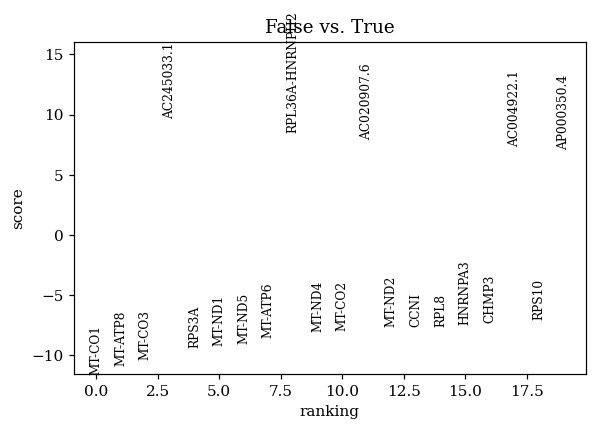

In [216]:
# sc_ns.annotate_genes(genes_annot_name="external_gene_name")
# adata=anndata.AnnData(sc_ns.mtx, obs={"pass_stringent":sc_ns.stringent.astype(str)}, var={"var_names":sc_ns.external_gene_name})
# scanpy.tl.rank_genes_groups(adata, groupby="pass_stringent", groups=["False"], reference= "True", method="t-test", use_raw = False, n_genes=len(sc_ns.external_gene_name), rankby_abs=True)
# scanpy.pl.rank_genes_groups(adata)

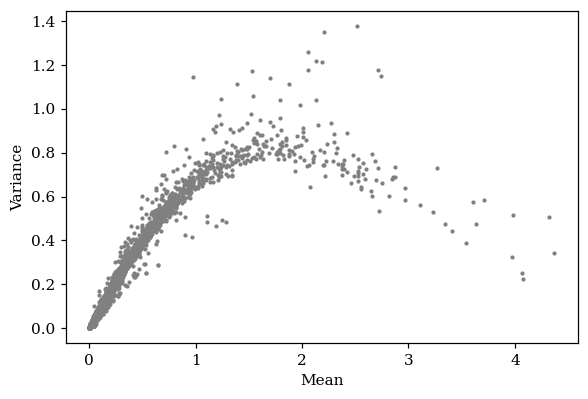

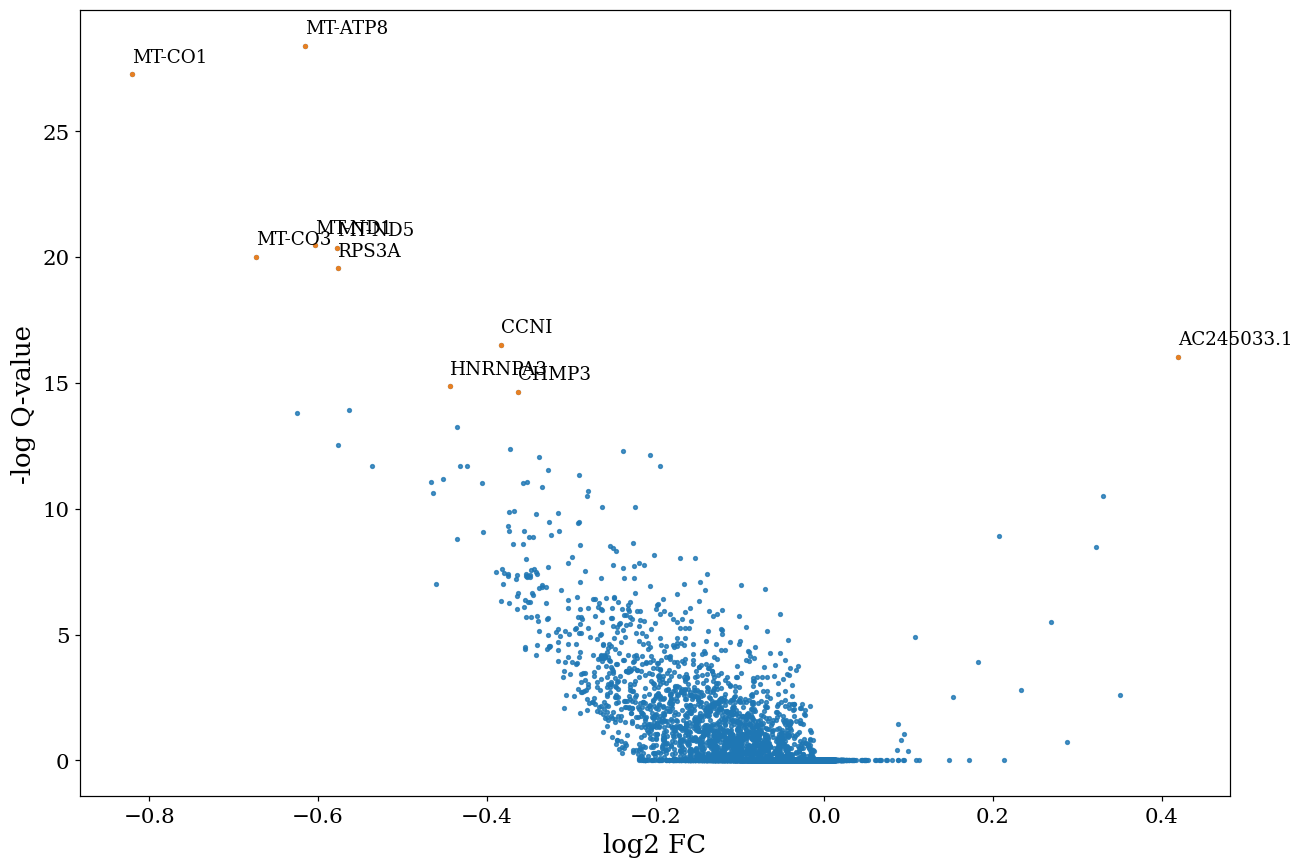


 Upregulatd : 
['AC245033.1' 'RPL36A-HNRNPH2' 'AC004922.1' 'AC020907.6' 'AP000350.4'
 'AL031847.2' 'AC010132.3' 'RPS10-NUDT3' 'MTRNR2L12' 'AC138811.2']

 Downregulatd : 
['MT-ATP8' 'MT-CO1' 'MT-ND1' 'MT-ND5' 'MT-CO3' 'RPS3A' 'CCNI' 'HNRNPA3'
 'CHMP3' 'MT-ND2' 'MT-ATP6' 'EIF1AX' 'MT-ND4' 'NAP1L1' 'LPP' 'CCNL1'
 'XRCC5' 'LMNA' 'PPP1R12A' 'CSDE1' 'MT-CO2' 'WASF2' 'NFIB' 'RPS10' 'KTN1'
 'YME1L1' 'SRSF11' 'RPL8' 'DSG2' 'GNB1' 'MTDH' 'KPNB1' 'MT-ND4L' 'ZFP36L1'
 'CYP1B1' 'BCAP31' 'FAM120A' 'PAK2' 'NIPBL' 'APOL6' 'CAMK2N1' 'HNRNPA1'
 'EIF5B' 'EBNA1BP2' 'CCDC50' 'RPL7' 'EIF4A1' 'ATP6V0E1' 'PSMD2' 'KIF5B'
 'CCAR1' 'RHOC' 'CYC1' 'PLCXD3' 'TTC3' 'WAC' 'SRP72' 'UBE3A' 'PSMB3'
 'NOP53' 'NUFIP2' 'DUT' 'SYNCRIP' 'GPAA1' 'EIF4G1' 'DIAPH1' 'GMPS'
 'GADD45GIP1' 'DDX17' 'MGST1' 'HNRNPM' 'PSME2' 'MARCKS' 'EPRS1' 'RACK1'
 'RPS3' 'PDIA6' 'CD63' 'NQO1' 'NRIP1' 'RPS9' 'GNAS' 'LRRFIP1' 'EEF1D'
 'YWHAB' 'HDGF' 'GSPT1' 'HNRNPF' 'ARHGAP21' 'SNW1' 'H2AZ2' 'GFPT1' 'ETFB'
 'MT-CYB' 'ICE1' 'TSPO' 'HK1' 'XRCC6' 'PRPF

In [749]:
qval_cutoff = 0.01
top = 10

sc_ns.reload()
sc_ns.filter_genes()
sc_ns.lib_size_normalization()
logfcs = sc_ns.log2FC(samples_annot_name="stringent", samples_annot_test="False", samples_annot_ref="True")
_, qvals = sc_ns.ttest(samples_annot_name="stringent", samples_annot_test="False", samples_annot_ref="True")

idx = np.argsort(qvals)
qvals = qvals[idx]
logfcs = logfcs[idx]
sc_ns.update_genes(idx)


#Volcano plot of results

logfcs_highlight = logfcs[:top]
qvals_highlight = qvals[:top]


fig, ax = plt.subplots(figsize=(12,8));
sb.regplot(logfcs, -np.log10(qvals), fit_reg=False, scatter_kws={'s':6})
sb.regplot(logfcs_highlight, -np.log10(qvals_highlight), fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=17)
ax.set_ylabel("-log Q-value", fontsize=17)
ax.tick_params(labelsize=14)

# # Label names and positions
labels = sc_ns.external_gene_name[:top]
x = [p for p in logfcs_highlight]
y = [i + 0.5 for i in -np.log10(qvals_highlight)]

# # Show only some labels to avoid overcrowding the figure
# to_remove = np.where([i < 130 for i in y])[0]
# labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]), fontsize=12)

plt.tight_layout()
plt.show()


print("\n Upregulatd : ")
print(sc_ns.external_gene_name[(qvals < qval_cutoff) & (logfcs > 0)])


print("\n Downregulatd : ")
print(sc_ns.external_gene_name[(qvals < qval_cutoff) & (logfcs < 0)])